height, width: 1400 850
unique values in mask: (array([0], dtype=uint8), array([1190000]))
x_start: 37, x_end: 797
unique values in mask: (array([0, 1, 2, 3], dtype=uint8), array([747770,  66561, 223753, 151916]))


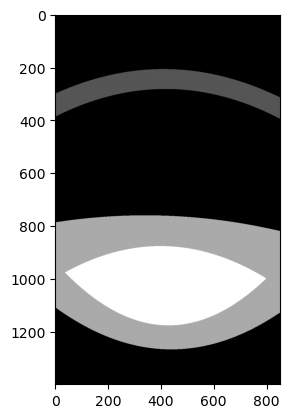

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv2

H, W = 4096, 850

data_root ="/media/be-light/Data/PG_Gdansk/Torun_secondment/Experiments/Training Data" 

segmentation = np.fromfile(data_root + "/CN043_DJ_18_M/OD/6-0D/2/Horizontal/Segmentation.bin", dtype = np.uint8)

# print('unique values in segmentation:', np.unique(segmentation, return_counts = True))

segmentation = segmentation[:H*W].reshape(W, H).T
segmentation = segmentation[:1400, :850]

binary_image = (segmentation == 255).astype(np.uint8)
# print('unique values in binary_image:', np.unique(binary_image, return_counts = True))

height, width = binary_image.shape
print('height, width:', height, width)
mask = np.zeros((height, width), np.uint8)
print('unique values in mask:', np.unique(mask, return_counts = True))
# ---- Layer pairs for segmentation ----
layer_pairs = {
    1 :(2, 3),  # Cornea
    2 :(4, 7),  # Lens
    3 :(5, 6)   # Nucleus
}

all_layers = [np.sort(np.where(binary_image[:, x] ==1)[0]) for x in range(width)]

def compute_x_range(layer_index):
    first_200 = [(x, all_layers[x][layer_index]) for x in range(min(200, width)) if len(all_layers[x]) > layer_index]
    last_200 = [(x, all_layers[x][layer_index]) for x in range(max(width-200, 0), width) if len(all_layers[x]) > layer_index]

    x_start = max(first_200, key=lambda item: item[1])[0] if first_200 else 0
    x_end = max(last_200, key=lambda item: item[1])[0] if last_200 else 0

    print(f"x_start: {x_start}, x_end: {x_end}")
    # print(f'first_200: {first_200}, last_200: {last_200}')

    return x_start, x_end

# def compute_y6_range(layer_index):
#     first_200_y6 = [(x, all_layers[x][layer_index]) for x in range(min(200, width)) if len(all_layers[x]) > layer_index]
#     last_200_y6 = [(x, all_layers[x][layer_index]) for x in range(max(width-200, 0), width) if len(all_layers[x]) > layer_index]

#     x_y6_start = min(first_200_y6, key=lambda item: item[1])[0] if first_200_y6 else 0
#     x_y6_end = min(last_200_y6, key=lambda item: item[1])[0] if last_200_y6 else 0

#     print(f"x_y6_start: {x_y6_start}, x_y6_end: {x_y6_end}")
#     # print(f'firsty6_200: {first_200_y6}, lasty6_200: {last_200_y6}')

#     return x_y6_start, x_y6_end

x5_start, x5_end = compute_x_range(4) # 5th layer (nucleus top)
# x6_start, x6_end = compute_y6_range(5) # 6th layer (nucleus bottom)

for x in range(width):
    ys = all_layers[x]
    if len(ys) == 0:
        continue
    
    for layer_num, (y_start, y_end) in layer_pairs.items():
        if y_start <= len(ys) and y_end <= len(ys):
            y_top, y_bottom = ys[y_start - 1], ys[y_end - 1]

            if layer_num == 3:  # Nucleus
                if x5_start is None or x5_end is None or not (x5_start + 1 <= x <= x5_end-1):
                    continue
            # if layer_num == 3:  # Nucleus
            #     if x6_start is None or x6_end is None or not (x6_start + 1 <= x < x6_end):
            #         continue

            label = cv2.line(mask, (x, y_top), (x, y_bottom), color=layer_num, thickness=1)
            
label = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8))
print('unique values in mask:', np.unique(label, return_counts = True))
plt.imshow(label, cmap='grey')
plt.show()

# plt.imshow(mask2)
# plt.show()

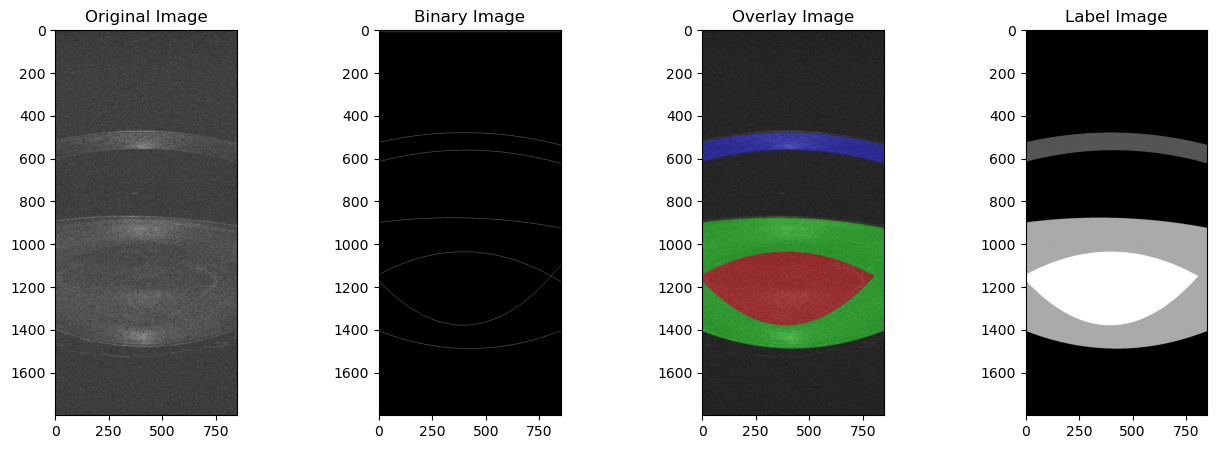

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv2

H, W = 4096, 850

data_root ="/media/be-light/Data/PG_Gdansk/Torun_secondment/Experiments/Training Data" 

# png_img = cv2.imread(data_root + "/CN043_DJ_18_M/OD/6-0D/6/Horizontal/Image.png", cv2.IMREAD_UNCHANGED)
png_img = cv2.imread(data_root + "/CN038_MM_37_F/OD/0-6D/0/Horizontal/Image.png", cv2.IMREAD_UNCHANGED)
# image = png_img[:1400, :850]  # crop to match segmentation size
image = png_img[:1800, :850] 
# segmentation = np.fromfile(data_root + "/CN043_DJ_18_M/OD/6-0D/6/Horizontal/Segmentation.bin", dtype = np.uint8)
segmentation = np.fromfile(data_root + "/CN038_MM_37_F/OD/0-6D/0/Horizontal/Segmentation.bin", dtype = np.uint8)

# print('unique values in segmentation:', np.unique(segmentation, return_counts = True))

segmentation1 = segmentation[:H*W].reshape(W, H).T
segmentation = segmentation1[:1800, :850]

binary_image = (segmentation == 255).astype(np.uint8)
# print('unique values in binary_image:', np.unique(binary_image, return_counts = True))

height, width = binary_image.shape
# print('height, width:', height, width)
mask = np.zeros((height, width), np.uint8)

# ---- Layer pairs for segmentation ----
layer_pairs = {
    1 :(2, 3),  # Cornea
    2 :(4, 7),  # Lens
    3 :(5, 6)   # Nucleus
}

color_map = {
    0: (0, 0, 0),       # black  - background
    1: (0, 0, 255),     # blue   - segment 1
    2: (0, 255, 0),     # green  - segment 2
    3: (255, 0, 0)      # red    - segment 3
}

all_layers = [np.sort(np.where(binary_image[:, x] ==1)[0]) for x in range(width)]

def compute_x_range(layer_index):
    first_200 = [(x, all_layers[x][layer_index]) for x in range(min(200, width)) if len(all_layers[x]) > layer_index]
    last_200 = [(x, all_layers[x][layer_index]) for x in range(max(width-200, 0), width) if len(all_layers[x]) > layer_index]

    x_start = max(first_200, key=lambda item: item[1])[0] if first_200 else 0
    x_end = max(last_200, key=lambda item: item[1])[0] if last_200 else 0

    # print(f"x_start: {x_start}, x_end: {x_end}")
    # print(f'first_200: {first_200}, last_200: {last_200}')

    return x_start, x_end


x5_start, x5_end = compute_x_range(4) # 5th layer (nucleus top)

for x in range(width):
    ys = all_layers[x]
    if len(ys) == 0:
        continue
    
    for layer_num, (y_start, y_end) in layer_pairs.items():
        if y_start <= len(ys) and y_end <= len(ys):
            y_top, y_bottom = ys[y_start - 1], ys[y_end - 1]

            if layer_num == 3:  # Nucleus
                if x5_start is None or x5_end is None or not (x5_start + 1 <= x <= x5_end-1):
                    continue

            label = cv2.line(mask, (x, y_top), (x, y_bottom), color=layer_num, thickness=1)
          

label = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8))
# color_mask = cv2.applyColorMap((label*10 ).astype(np.uint8), cv2.COLORMAP_JET)

color_label = np.zeros((label.shape[0], label.shape[1], 3), dtype=np.uint8)
for k, color in color_map.items():
    color_label[label == k] = color

overlay = cv2.addWeighted(image, 0.6, color_label, 0.4, 0)

plt.figure(figsize=(16, 5))
plt.subplot(1, 4, 1)
plt.title("Original Image")
plt.imshow(image)

plt.subplot(1, 4, 2)
plt.title("Binary Image")
plt.imshow(binary_image, cmap="gray")

plt.subplot(1, 4, 3)
plt.title("Overlay Image")
plt.imshow(overlay)

plt.subplot(1, 4, 4)
plt.title("Label Image")
plt.imshow(label, cmap='grey')
plt.show()


In [30]:
def resize_with_padding(img, target_size=(512, 512)):
    h, w = img.shape[:2]
    th, tw = target_size

    # Scale while keeping aspect ratio
    scale = min(tw / w, th / h)
    new_w, new_h = int(w * scale), int(h * scale)

    # Resize
    resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_NEAREST)

    # Pad to target size
    pad_w = (tw - new_w) // 2
    pad_h = (th - new_h) // 2
    padded = cv2.copyMakeBorder(resized, pad_h, th-new_h-pad_h,
                                pad_w, tw-new_w-pad_w,
                                cv2.BORDER_CONSTANT, value=0)
    return padded

In [32]:
import os
import cv2
import numpy as np
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

print("current working dir:", os.getcwd())

resize = True
# --- Paths ---
data_root = "./dataset"  # root dataset folder
save_images = data_root + "/images"
save_labels = data_root + "/labels"
save_visual = data_root + "/visual"
os.makedirs(save_images, exist_ok=True)
os.makedirs(save_labels, exist_ok=True)
os.makedirs(save_visual, exist_ok=True)


H, W = 4096, 850

data_root ="/media/be-light/Data/PG_Gdansk/Torun_secondment/Experiments/Training Data" 

png_img = cv2.imread(data_root + "/CN043_DJ_18_M/OD/6-0D/2/Horizontal/Image.png", cv2.IMREAD_UNCHANGED)
image = png_img[:1400, :850]  # crop to match segmentation size

segmentation = np.fromfile(data_root + "/CN043_DJ_18_M/OD/6-0D/2/Horizontal/Segmentation.bin", dtype = np.uint8)

# print('unique values in segmentation:', np.unique(segmentation, return_counts = True))

segmentation = segmentation[:H*W].reshape(W, H).T
segmentation = segmentation[:1400, :850]

binary_image = (segmentation == 255).astype(np.uint8)
# print('unique values in binary_image:', np.unique(binary_image, return_counts = True))

height, width = binary_image.shape
# print('height, width:', height, width)
mask = np.zeros((height, width), np.uint8)

# ---- Layer pairs for segmentation ----
layer_pairs = {
    1 :(2, 3),  # Cornea
    2 :(4, 7),  # Lens
    3 :(5, 6)   # Nucleus
}

color_map = {
    0: (0, 0, 0),       # black  - background
    1: (0, 0, 255),     # blue   - segment 1
    2: (0, 255, 0),     # green  - segment 2
    3: (255, 0, 0)      # red    - segment 3
}

all_layers = [np.sort(np.where(binary_image[:, x] ==1)[0]) for x in range(width)]

def compute_x_range(layer_index):
    first_200 = [(x, all_layers[x][layer_index]) for x in range(min(200, width)) if len(all_layers[x]) > layer_index]
    last_200 = [(x, all_layers[x][layer_index]) for x in range(max(width-200, 0), width) if len(all_layers[x]) > layer_index]

    x_start = max(first_200, key=lambda item: item[1])[0] if first_200 else 0
    x_end = max(last_200, key=lambda item: item[1])[0] if last_200 else 0

    # print(f"x_start: {x_start}, x_end: {x_end}")
    # print(f'first_200: {first_200}, last_200: {last_200}')

    return x_start, x_end


x5_start, x5_end = compute_x_range(4) # 5th layer (nucleus top)

for x in range(width):
    ys = all_layers[x]
    if len(ys) == 0:
        continue
    
    for layer_num, (y_start, y_end) in layer_pairs.items():
        if y_start <= len(ys) and y_end <= len(ys):
            y_top, y_bottom = ys[y_start - 1], ys[y_end - 1]

            if layer_num == 3:  # Nucleus
                if x5_start is None or x5_end is None or not (x5_start + 1 <= x <= x5_end-1):
                    continue

            label = cv2.line(mask, (x, y_top), (x, y_bottom), color=layer_num, thickness=1)
          

label = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8))
# color_mask = cv2.applyColorMap((label*10 ).astype(np.uint8), cv2.COLORMAP_JET)

color_label = np.zeros((label.shape[0], label.shape[1], 3), dtype=np.uint8)
for k, color in color_map.items():
    color_label[label == k] = color

if resize:
    image = resize_with_padding(image, target_size=(512, 512))
    label = resize_with_padding(label, target_size=(512, 512))
    color_label = resize_with_padding(color_label, target_size=(512, 512))

cv2.imwrite(os.path.join(save_images, f"image.png"), image)
cv2.imwrite(os.path.join(save_labels, f"label.png"), label)
np.save(os.path.join(save_labels, f"label.npy"), label)
cv2.imwrite(os.path.join(save_visual, f"visual.png"), color_label)

current working dir: /media/be-light/Data/PG_Gdansk/Torun_secondment/Experiments/dataset_eye


True

In [43]:
def annotation(image_path, seg_path, resize=True):
    # data_root ="/media/be-light/Data/PG_Gdansk/Torun_secondment/Experiments/Training Data" 

    png_img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    image = png_img[:1400, :850]  # crop to match segmentation size

    segmentation = np.fromfile(seg_path, dtype=np.uint8)

    # print('unique values in segmentation:', np.unique(segmentation, return_counts = True))

    segmentation = segmentation[:H*W].reshape(W, H).T
    segmentation = segmentation[:1400, :850]

    binary_image = (segmentation == 255).astype(np.uint8)
    # print('unique values in binary_image:', np.unique(binary_image, return_counts = True))

    height, width = binary_image.shape
    # print('height, width:', height, width)
    mask = np.zeros((height, width), np.uint8)

    # ---- Layer pairs for segmentation ----
    layer_pairs = {
        1 :(2, 3),  # Cornea
        2 :(4, 7),  # Lens
        3 :(5, 6)   # Nucleus
    }

    color_map = {
        0: (0, 0, 0),       # black  - background
        1: (0, 0, 255),     # blue   - segment 1
        2: (0, 255, 0),     # green  - segment 2
        3: (255, 0, 0)      # red    - segment 3
    }

    all_layers = [np.sort(np.where(binary_image[:, x] ==1)[0]) for x in range(width)]

    def compute_x_range(layer_index):
        first_200 = [(x, all_layers[x][layer_index]) for x in range(min(200, width)) if len(all_layers[x]) > layer_index]
        last_200 = [(x, all_layers[x][layer_index]) for x in range(max(width-200, 0), width) if len(all_layers[x]) > layer_index]

        x_start = max(first_200, key=lambda item: item[1])[0] if first_200 else 0
        x_end = max(last_200, key=lambda item: item[1])[0] if last_200 else 0

        # print(f"x_start: {x_start}, x_end: {x_end}")
        # print(f'first_200: {first_200}, last_200: {last_200}')

        return x_start, x_end


    x5_start, x5_end = compute_x_range(4) # 5th layer (nucleus top)

    for x in range(width):
        ys = all_layers[x]
        if len(ys) == 0:
            continue
        
        for layer_num, (y_start, y_end) in layer_pairs.items():
            if y_start <= len(ys) and y_end <= len(ys):
                y_top, y_bottom = ys[y_start - 1], ys[y_end - 1]

                if layer_num == 3:  # Nucleus
                    if x5_start is None or x5_end is None or not (x5_start + 1 <= x <= x5_end-1):
                        continue
                   

                label = cv2.line(mask, (x, y_top), (x, y_bottom), color=layer_num, thickness=1)
            

    label = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8))
    # color_mask = cv2.applyColorMap((label*10 ).astype(np.uint8), cv2.COLORMAP_JET)

    color_label = np.zeros((label.shape[0], label.shape[1], 3), dtype=np.uint8)
    for k, color in color_map.items():
        color_label[label == k] = color

    if resize:
        image = resize_with_padding(image, target_size=(512, 512))
        label = resize_with_padding(label, target_size=(512, 512))
        color_label = resize_with_padding(color_label, target_size=(512, 512))
    return image, label, color_label

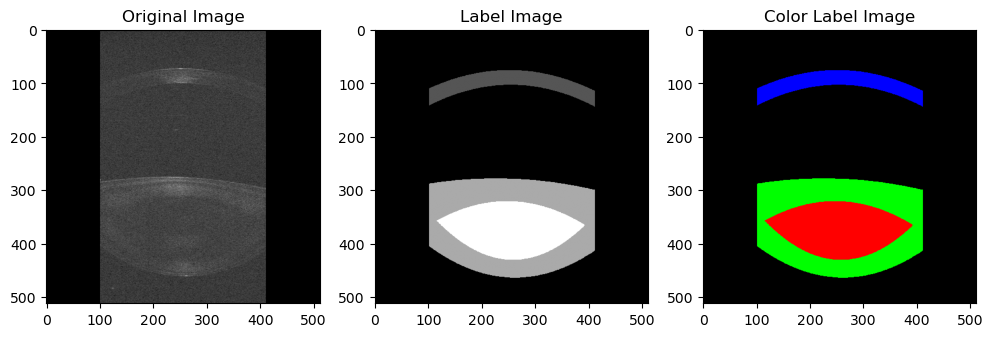

In [37]:
data_root ="/media/be-light/Data/PG_Gdansk/Torun_secondment/Experiments/Training Data" 

png_img = data_root + "/CN043_DJ_18_M/OD/6-0D/2/Horizontal/Image.png"
segmentation = data_root + "/CN043_DJ_18_M/OD/6-0D/2/Horizontal/Segmentation.bin"

image, label, color_label = annotation(png_img, segmentation)

plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image)   
plt.subplot(1, 3, 2)
plt.title("Label Image")
plt.imshow(label, cmap='grey')
plt.subplot(1, 3, 3)
plt.title("Color Label Image")
plt.imshow(color_label)
plt.show()

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm

# --- paths ---
main_dir = "/media/be-light/Data/PG_Gdansk/Torun_secondment/Experiments/Training Data"


data_root = "./dataset"  # root dataset folder
save_images = data_root + "/images"
save_labels = data_root + "/labels"
save_visual = data_root + "/visual"
os.makedirs(save_images, exist_ok=True)
os.makedirs(save_labels, exist_ok=True)
os.makedirs(save_visual, exist_ok=True)

# --- recursively loop through all directories ---
for root, dirs, files in os.walk(main_dir):
    if "Segmentation.bin" in files and "Image.png" in files:
        seg_path = os.path.join(root, "Segmentation.bin")
        img_path = os.path.join(root, "Image.png")

        # --- build a clean unique name ---
        rel_path = os.path.relpath(root, main_dir)  # relative path
        parts = rel_path.split(os.sep)
        # e.g. ['CN043_DJ_18_M', 'OD', '6-0D', '6', 'Horizontal']
        if len(parts) >= 5:
            base_name = f"{parts[0]}_{parts[1]}_{parts[2]}_{parts[3]}_{parts[4]}"
        else:
            base_name = "_".join(parts)


        image, label, color_label = annotation(img_path, seg_path)

        # --- save outputs ---
        img_out = os.path.join(save_images, f"{base_name}.png")
        lbl_out = os.path.join(save_labels, f"{base_name}.png")
        vis_out = os.path.join(save_visual, f"{base_name}.png")

        cv2.imwrite(img_out, image)
        cv2.imwrite(lbl_out, label)
        cv2.imwrite(vis_out, color_label)

        # print(f"✅ Saved {base_name}")


In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed

# --- paths ---
main_dir = "/media/be-light/Data/PG_Gdansk/Torun_secondment/Experiments/Training Data"
data_root = "./dataset"  # root dataset folder

save_images = os.path.join(data_root, "images")
save_labels = os.path.join(data_root, "labels")
save_visual = os.path.join(data_root, "visual")

os.makedirs(save_images, exist_ok=True)
os.makedirs(save_labels, exist_ok=True)
os.makedirs(save_visual, exist_ok=True)

# --- function for single sample processing ---
def process_sample(root):
    try:
        seg_path = os.path.join(root, "Segmentation.bin")
        img_path = os.path.join(root, "Image.png")

        # --- build clean unique name ---
        rel_path = os.path.relpath(root, main_dir)
        parts = rel_path.split(os.sep)
        base_name = "_".join(parts[:5]) if len(parts) >= 5 else "_".join(parts)

        img_out = os.path.join(save_images, f"{base_name}.png")
        lbl_out = os.path.join(save_labels, f"{base_name}.png")
        vis_out = os.path.join(save_visual, f"{base_name}.png")

        # --- skip if already processed ---
        if os.path.exists(lbl_out) and os.path.exists(vis_out):
            return f"⏩ Skipped {base_name}"

        # --- run your annotation function ---
        image, label, color_label = annotation(img_path, seg_path)

        # --- save outputs ---
        cv2.imwrite(img_out, image)
        cv2.imwrite(lbl_out, label)
        cv2.imwrite(vis_out, color_label)

        return f"✅ Saved {base_name}"

    except Exception as e:
        return f"❌ Error in {root}: {str(e)}"


# --- collect all folders that contain required files ---
all_folders = []
for root, dirs, files in os.walk(main_dir):
    if "Segmentation.bin" in files and "Image.png" in files:
        all_folders.append(root)

print(f"📁 Found {len(all_folders)} valid samples to process.\n")

# --- toggle for parallel execution ---
use_parallel = True  # set to False for debugging

if use_parallel:
    with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        futures = {executor.submit(process_sample, folder): folder for folder in all_folders}
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing"):
            print(future.result())
else:
    for folder in tqdm(all_folders, desc="Processing"):
        print(process_sample(folder))

print("\n✅ All done.")


In [61]:
import os
import shutil
import random

# Paths
root = '/media/be-light/Data/PG_Gdansk/Torun_secondment/Experiments/dataset_eye/dataset/eye_data'  # Replace with your root path
images_dir = os.path.join('/media/be-light/Data/PG_Gdansk/Torun_secondment/Experiments/dataset_eye/dataset/images')   #(root, 'images_all')  # All images in one folder
labels_dir = os.path.join('/media/be-light/Data/PG_Gdansk/Torun_secondment/Experiments/dataset_eye/dataset/labels')   #(root, 'labels_all')  # All GTs in one folder
visual_dir = os.path.join('/media/be-light/Data/PG_Gdansk/Torun_secondment/Experiments/dataset_eye/dataset/visual')   #(root, 'visual')  # All visualizations in one folder

print("Images source:", images_dir)
print("Labels source:", labels_dir)
print("Visual source:", visual_dir)
import os
import shutil
import random
from glob import glob

# Output structure
for sub in ["images/train", "images/val", "labels/train", "labels/val", "visual/train", "visual/val"]:
    os.makedirs(os.path.join(root, sub), exist_ok=True)

# Collect all images
image_files = glob(os.path.join(images_dir, "*.png"))

# Shuffle for random split
random.seed(42)
random.shuffle(image_files)

# Train/val split (80/20)
split_idx = int(0.8 * len(image_files))
train_images = image_files[:split_idx]
val_images = image_files[split_idx:]

def copy_pairs(image_list, split):
    for img_path in image_list:
        img_name = os.path.basename(img_path)
     
        # Derive label name from image name
        # Example: CN038_..._Vertical_leftImg8bit.png
        # Label:  CN038_..._Vertical_gtFine_labelIds.png
        base_name = img_name    #.replace("leftImg8bit", "gtFine_labelIds")
        label_path = os.path.join(labels_dir, base_name)
        visual_path = os.path.join(visual_dir, base_name)

        # image_name2 = img_name.replace("leftImg8bit", "image")
        # label_name2 = base_name.replace("gtFine_labelIds", "label")
        if not os.path.exists(label_path):
            print(f"[WARN] Label not found for {img_name}")
            continue
        if not os.path.exists(visual_path):
            print(f"[WARN] Visual not found for {img_name}")
            continue
        # Copy image and label
        shutil.copy(img_path, os.path.join(root, f"images/{split}", img_name))
        shutil.copy(label_path, os.path.join(root, f"labels/{split}", base_name))
        shutil.copy(visual_path, os.path.join(root, f"visual/{split}", base_name))

        # shutil.copy(img_path, os.path.join(root, f"images/{split}", image_name2))
        # shutil.copy(label_path, os.path.join(root, f"labels/{split}", label_name2))

# Copy train/val sets
copy_pairs(train_images, "train")
copy_pairs(val_images, "val")

print(f"✅ Done! Train: {len(train_images)} | Val: {len(val_images)}")



Images source: /media/be-light/Data/PG_Gdansk/Torun_secondment/Experiments/dataset_eye/dataset/images
Labels source: /media/be-light/Data/PG_Gdansk/Torun_secondment/Experiments/dataset_eye/dataset/labels
Visual source: /media/be-light/Data/PG_Gdansk/Torun_secondment/Experiments/dataset_eye/dataset/visual
✅ Done! Train: 326 | Val: 82
